# Scope
- Eval user logs
- Data enrichment
- Tool use
- Other stuff

# Eval user logs

In [14]:
# setup
import os
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime
from dotenv import load_dotenv

# Load environment variables from both .env and shell
load_dotenv()  # This adds .env variables to os.environ

def create_engine_with_params(db_params: dict) -> create_engine:
    """Create SQLAlchemy engine using database parameters."""
    url = f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}"
    return create_engine(url)

db_params = {
    "dbname": "postgres", 
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": "5432"  # Default port for PostgreSQL
}

engine = create_engine_with_params(db_params)

In [2]:
df = pd.read_sql_query("SELECT * FROM events", con=engine)
df.sort_values(by="timestamp", ascending=False).head()

,event_id,timestamp,session_id,type,data,metadata
207,1084daf6-6958-4449-98ec-80720ad22b92,2025-02-04 03:01:13.834022+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_created,"{'input': 'Yoda', 'output': {'template_id': '1...","{'environment': 'development', 'timestamp_utc'..."
206,049f5d53-5319-42a3-b27e-777a4814e449,2025-02-04 03:01:08.003715+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_liked,{'image_url': 'https://i.imgflip.com/9iz34g.jpg'},"{'environment': 'development', 'timestamp_utc'..."
205,246dbd96-2f4a-4edd-9f47-0b222b90613c,2025-02-04 03:00:59.150591+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_created,"{'input': 'Yoda', 'output': {'template_id': '1...","{'environment': 'development', 'timestamp_utc'..."
204,a34edc20-5a4a-4924-ada2-cf6ddd310f78,2025-02-04 03:00:49.642221+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_liked,{'image_url': 'https://i.imgflip.com/9iz33d.jpg'},"{'environment': 'development', 'timestamp_utc'..."
203,86aa7dbf-54f1-4ec4-8481-50b1502d4280,2025-02-04 03:00:47.193368+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_liked,{'image_url': 'https://i.imgflip.com/9iz33d.jpg'},"{'environment': 'development', 'timestamp_utc'..."


In [5]:
# how many sessions since go live
sql = """
select
    date(timestamp) as event_day,
    count(distinct session_id) as session_count,
    sum(case when type = 'meme_created' then 1 else 0 end) as memes_created,
    sum(case when type = 'meme_liked' then 1 else 0 end) as memes_liked,
    sum(case when type = 'error' then 1 else 0 end) as errors
from events
where timestamp >= current_date - interval '7 days'
    and timestamp < current_date + interval '1 day'
group by 1
order by 1 asc;
"""
pd.read_sql_query(sql, con=engine)

,event_day,session_count,memes_created,memes_liked,errors
0,2025-01-29,6,11,1,1
1,2025-01-30,21,38,2,16
2,2025-01-31,23,99,10,6
3,2025-02-01,2,6,0,0
4,2025-02-04,1,5,3,0


In [13]:
# who used the thing today?
pd.read_sql_query(
    """
    select  
    timestamp,
    session_id,
    type,
    data,
    data->>'input' as input,
    data->>'output' as output,
    data->>'template_id' as template_id,
    data->>'image_url' as image_url
    from events where date(timestamp) = '2025-02-04'
    order by 1 asc
    """
    , con=engine)

,timestamp,session_id,type,data,input,output,template_id,image_url
0,2025-02-04 03:00:03.080934+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_created,"{'input': 'Yoda', 'output': {'text0': 'Yoda is...",Yoda,"{""text0"": ""Yoda is a Jedi Master"", ""text1"": """"...",129242436,https://i.imgflip.com/9iz31x.jpg
1,2025-02-04 03:00:19.415605+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_created,"{'input': 'Yoda', 'output': {'template_id': '1...",Yoda,"{""template_id"": ""112126428"", ""boxes[0][text]"":...",112126428,https://i.imgflip.com/9iz32m.jpg
2,2025-02-04 03:00:37.791161+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_created,"{'input': 'Yoda', 'output': {'text0': 'Using t...",Yoda,"{""text0"": ""Using the Force"", ""text1"": ""Struggl...",181913649,https://i.imgflip.com/9iz33d.jpg
3,2025-02-04 03:00:47.193368+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_liked,{'image_url': 'https://i.imgflip.com/9iz33d.jpg'},None,None,None,https://i.imgflip.com/9iz33d.jpg
4,2025-02-04 03:00:49.642221+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_liked,{'image_url': 'https://i.imgflip.com/9iz33d.jpg'},None,None,None,https://i.imgflip.com/9iz33d.jpg
5,2025-02-04 03:00:59.150591+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_created,"{'input': 'Yoda', 'output': {'template_id': '1...",Yoda,"{""template_id"": ""124822590"", ""boxes[0][text]"":...",124822590,https://i.imgflip.com/9iz34g.jpg
6,2025-02-04 03:01:08.003715+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_liked,{'image_url': 'https://i.imgflip.com/9iz34g.jpg'},None,None,None,https://i.imgflip.com/9iz34g.jpg
7,2025-02-04 03:01:13.834022+00:00,f64b815f-2ab9-4d67-9338-cc5f33055c30,meme_created,"{'input': 'Yoda', 'output': {'template_id': '1...",Yoda,"{""template_id"": ""112126428"", ""boxes[0][text]"":...",112126428,https://i.imgflip.com/9iz35c.jpg


In [30]:
# Which inputs produced memes that have errored since Jan 31?
sql = """
select distinct data->>'prompt' as input
from events
where timestamp >= '2025-01-31'
and type = 'error'
"""
pd.read_sql_query(sql, con=engine)['input'].to_list()
# make the input key consistent in future
# make it easier to differentiate test events from prod

['i want to represent that a builder of an app will be surprised when they see the real user data.\n',
 "Toddler is not impressed with his dad's cooking\n",
 "Toddler is not impressed with his dad's cooking"]

In [ ]:
# example session where there is a problem
pd.read_sql_query("select *, data->>'input' as input, data->>'output' as output from events where session_id = 'c337bb56-905a-43d9-94c6-d30a0813647d' order by timestamp asc", con=engine)
# log whatever the output from LLM is

,event_id,timestamp,session_id,type,data,metadata,input,output
0,3df066cc-21f5-499c-995c-cf9699ad0f96,2025-01-31 03:18:56.216798+00:00,c337bb56-905a-43d9-94c6-d30a0813647d,meme_created,{'input': 'i want to represent that a builder ...,"{'environment': 'development', 'timestamp_utc'...",i want to represent that a builder of an app w...,"{""template_id"": ""112126428"", ""boxes[0][text]"":..."
1,4b56bf96-9fa4-4295-9a93-98228b273dcd,2025-01-31 03:19:31.747154+00:00,c337bb56-905a-43d9-94c6-d30a0813647d,error,{'prompt': 'i want to represent that a builder...,"{'environment': 'development', 'timestamp_utc'...",None,None
2,96e44e4e-dd78-4209-bb3a-93236ac83699,2025-01-31 03:19:41.856280+00:00,c337bb56-905a-43d9-94c6-d30a0813647d,meme_created,{'input': 'i want to represent that a builder ...,"{'environment': 'development', 'timestamp_utc'...",i want to represent that a builder of an app w...,"{""template_id"": ""112126428"", ""boxes[0][text]"":..."
3,e7b2d481-7f8d-4aa2-acd6-820a09323263,2025-01-31 03:19:51.944979+00:00,c337bb56-905a-43d9-94c6-d30a0813647d,error,{'prompt': 'i want to represent that a builder...,"{'environment': 'development', 'timestamp_utc'...",None,None


In [ ]:
pd.read_sql_query("select data from events where type = 'meme_liked' order  by random() limit 5", con=engine)['data'].to_list()
# we need to clean up our events! Consistent data!!!

[{'image_url': 'https://i.imgflip.com/9ik1x8.jpg'},
 {'image_url': 'https://i.imgflip.com/9ik08s.jpg'},
 {'image_url': 'https://i.imgflip.com/9ik3jq.jpg'},
 {'image_url': 'https://i.imgflip.com/9ik8kv.jpg'},
 {'image_url': 'https://i.imgflip.com/9iexi0.jpg'}]

In [42]:
# what are prompts where the user tried a lot and wasn't happy
data = pd.read_sql(
    """
    select session_id, coalesce(data->>'input',data->>'prompt') as input, count(event_id) as attempts, sum(case when type = 'meme_liked' then 1 else 0 end) as likes
    from events
    where timestamp >= '2025-01-31'
    group by 1,2
    /*having sum(case when type = 'meme_liked' then 1 else 0 end) = 0*/
    order by 3 desc
    """,
    con=engine
)
data.iloc[35]

session_id                 b7cc8aa2-2933-4dc2-b50b-977d719bb05f
input         Show a 4 panel meme. Starting with it looking ...
attempts                                                      1
likes                                                         0
Name: 35, dtype: object

In [44]:
# this is fascinating - very descriptive, likely trained from Dall-e or midjourney.
data.iloc[35]['input']

'Show a 4 panel meme. Starting with it looking like two people are having a meaningful phone message conversation. Then pan out and show one of them is being given their material by AI. Then zoom out again and show they both are'

<Axes: ylabel='Frequency'>

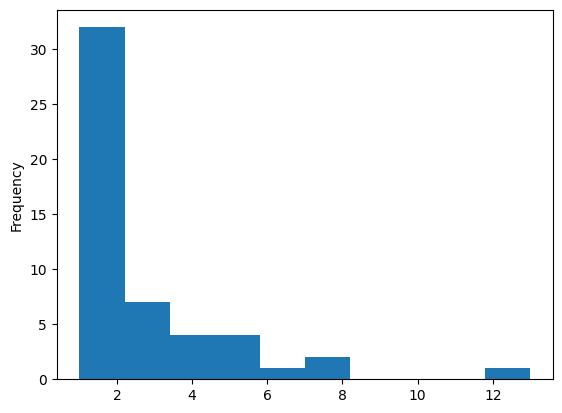

In [45]:
import matplotlib.pyplot as plt
data.attempts.plot(kind='hist')

In [46]:
data

,session_id,input,attempts,likes
0,ce21806b-445f-42c5-a2b8-1b2b6cc294eb,"I am trying to make a funny meme, but my sense...",13,0
1,ce21806b-445f-42c5-a2b8-1b2b6cc294eb,"I am trying to make a funny meme using AI, but...",8,0
2,251b47a1-b7e3-449d-b405-ff63edacd317,Pharmacy overlord,7,0
3,0cdb9822-c0ff-4537-ae89-21a0471c30a3,Deep seek a Chinese AI model after being asked...,6,0
4,f64b815f-2ab9-4d67-9338-cc5f33055c30,Yoda,5,0
5,17c38bcf-f2f5-4fe4-bc2e-5e1fb11cc054,Prompt engineering vs fine-tuning\n,5,0
6,32b6c412-401b-4d5d-bc49-6b5aa3ae84ef,Please create me a funny meme about parents an...,5,0
7,17c38bcf-f2f5-4fe4-bc2e-5e1fb11cc054,Prompt engineering vs fine-tuning,5,0
8,12657575-5518-4932-a1db-262df9685003,Overengineering LLM Apps,4,0
9,ce21806b-445f-42c5-a2b8-1b2b6cc294eb,"I am trying to make a funny meme, but my sense...",4,0


In [65]:
# dump unique prompts for testing
import pickle
prompts = data['input'].str.strip().drop_duplicates().dropna().to_list()
with open('../data/evals/prompts.pkl','wb') as handle:
    pickle.dump(prompts,handle)

In [66]:
# 29 prompts since Jan 31
len(prompts)

29

## Findings
- Consistent keys are needed - e.g. input and output should be appended to "like"
- Some better ideas on meme options should be shown 

# Moar Data!

In [48]:
import requests
import pandas as pd
import json
url = 'https://api.imgflip.com/get_memes'
r = requests.get(url)
all_memes = pd.DataFrame(json.loads(r.content)['data']['memes'])
annotated_memes = pd.read_pickle('../data/processed/memes20250128.pkl') 
display(
    all_memes.head(),
    annotated_memes.head()
)

,id,name,url,width,height,box_count,captions
0,181913649,Drake Hotline Bling,https://i.imgflip.com/30b1gx.jpg,1200,1200,2,1366750
1,87743020,Two Buttons,https://i.imgflip.com/1g8my4.jpg,600,908,3,1058500
2,112126428,Distracted Boyfriend,https://i.imgflip.com/1ur9b0.jpg,1200,800,3,1080500
3,217743513,UNO Draw 25 Cards,https://i.imgflip.com/3lmzyx.jpg,500,494,2,589500
4,131087935,Running Away Balloon,https://i.imgflip.com/261o3j.jpg,761,1024,5,558250


,id,name,url,width,height,box_count,captions,kym_definition,kym_examples,imgflip_api_post
0,181913649,Drake Hotline Bling,https://i.imgflip.com/30b1gx.jpg,1200,1200,2,1364500,\nDrakeposting refers to the practice of posti...,[\n {\n 'text0': 'Waiting for your i...,"\n{\n 'template_id':'181913649',\n 'user..."
1,87743020,Two Buttons,https://i.imgflip.com/1g8my4.jpg,600,908,3,1057000,"\n""Daily Struggle"" is an exploitable comic fea...","[\n {\n 'text0': 'Be a Dick',\n ...","\n{\n 'template_id':'181913649',\n 'user..."
2,112126428,Distracted Boyfriend,https://i.imgflip.com/1ur9b0.jpg,1200,800,3,1079250,"\nDistracted Boyfriend, also known as Man Look...","[\n {\n 'text0': 'Socialism', # the ...","\n{\n 'template_id':'112126428',\n 'user..."
3,217743513,UNO Draw 25 Cards,https://i.imgflip.com/3lmzyx.jpg,500,494,2,588250,\nDraw 25 refers to a two-paneled image macro ...,[\n {\n 'text0': 'Acknowledge that y...,"\n{\n 'template_id':'217743513',\n 'user..."
4,131087935,Running Away Balloon,https://i.imgflip.com/261o3j.jpg,761,1024,5,556750,\nRunning Away Balloon is a two-panel exploita...,"[\n {\n 'text0': 'Me', # top panel, ...","\n{\n 'template_id':'131087935',\n 'user..."


In [49]:
working_df = all_memes.merge(annotated_memes[['id','kym_definition','kym_examples','imgflip_api_post']],on='id',how='left')
working_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                100 non-null    object
 1   name              100 non-null    object
 2   url               100 non-null    object
 3   width             100 non-null    int64 
 4   height            100 non-null    int64 
 5   box_count         100 non-null    int64 
 6   captions          100 non-null    int64 
 7   kym_definition    10 non-null     object
 8   kym_examples      10 non-null     object
 9   imgflip_api_post  10 non-null     object
dtypes: int64(4), object(6)
memory usage: 7.9+ KB


In [55]:
print(working_df.name.iloc[8])

Epic Handshake


In [54]:
print(working_df.kym_definition.iloc[8])


Epic Handshake, also known as the Predator Handshake, is a memorable scene from the 1987 science fiction action film Predator in which two men greet each other with an arm-wrestle handshake. Due to the campy nature of the scene, it has inspired many parody and remix videos on YouTube, often featuring background music using popular songs from the 1980s. In the 2010s and beyond, a watercolor painting depicting the handshake became a prevalent object-labeling meme format online with captions added to both arms and the hands in the middle, typically to show agreement between two parties on something.



In [53]:
print(working_df.kym_examples.iloc[8])

[
    {
        'text0': 'not calling the police', # what they agree on
        'text1': 'rap', # right arm from left person
        'text2': 'punk', # left arm from right person
    },
    {
        'text0': 'constantly worrying about drivers', # what they agree on
        'text1': 'cyclists', # left arm
        'text2': 'linux users', # right arm
    },    
]


In [52]:
print(working_df.imgflip_api_post.iloc[8])


{
    'template_id':'135256802',
    'username': IMGFLIP_USERNAME,
    'password': IMGFLIP_PASSWORD,
    'boxes[0][text]': 'not calling the police', # what they agree on
    'boxes[1][text]': 'rap', # left arm
    'boxes[2][text]': 'punk', # right arm
}

